<a href="https://colab.research.google.com/github/Lemonfry/ds-section1-project/blob/main/section1-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

게임 개발을 위한 데이터 분석

---


목표 : 다음 분기에 설계할 게임 결정하기

가진 데이터 : 무슨 장르의 게임이 어느 년도에 어떤 기종(platform)으로 출시되었으며, 만든 회사는 어디고 북미/유럽/일본/기타 지역에서의 출고 실적

단순하게 생각한다면 가장 많이 팔리는 장르만 확인하여 모든 게임 기종으로 모든 지역에 판매하면 되겠으나, 개발 시간 제한 및 비용의 이유로 인해 그러기는 힘듭니다.

그래서 잘 팔리는 게임을 위해

1. 가장 많이 팔리는 장르
2. 가장 많이 팔리는 기종
3. 가장 많이 팔리는 지역

을 확인하고자 합니다.

(분석을 위해, 출고량이 높으면 판매량도 많다고 생각하겠습니다)

진행 과정에 따른 설명은 코드를 참조해 주세요
1. 데이터 전처리(EDA)

In [1]:
# 기종 항목이 누락되어 한칸씩 당겨진 2개의 항목이 있어,(7597번, 16192번) 직접 수정합니다.
# 마찬가지로 연도가 네자리가 아닌 경우들도 직접 수정합니다.(14 -> 2014, 99 -> 1999, 0 -> 2000 등)

In [2]:
# 개인 노트북에 저장한 파일 불러오기
from google.colab import files
myfile = files.upload()

Saving vgames2_modified.csv to vgames2_modified.csv


In [3]:
import io
import pandas as pd
game_data = pd.read_csv(io.BytesIO(myfile['vgames2_modified.csv']))

In [4]:
# game_data

In [5]:
# unamed:0 column을 제거합니다
game_data = game_data.drop(['Unnamed: 0'], axis = 1)

In [6]:
# game_data

In [7]:
# Sales 항목의 수를 M(백만) 단위로 맞추기 : 여러 게임 관련 기사를 볼 때, 출고량의 기본 단위는 M이며 단위가 누락된 게임들도 M 단위 출고량에 더 가까운 것으로 보입니다.
# (단위 없는 판매량 중 1985 슈퍼마리오의 출고량이 41.49인데, 가디언지 온라인 기사에서 4000만장(40M) 팔렸단 기사로 볼때 M으로 계산 가능할 것으로 생각됨)
# https://www.theguardian.com/technology/gamesblog/2010/sep/13/games-gameculture, 10번항목
# 결론 : 단위 없으면 M으로 계산, K 단위는 M으로 변환합니다.

In [8]:
# M단위 통일을 위해 M단위는 문자만 없애고, K단위 발견시 K는 없애고 출고량이 M단위로 바뀌도록 0.001을 곱합니다.
game_data.NA_Sales = (game_data.NA_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.NA_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.EU_Sales = (game_data.EU_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.EU_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.JP_Sales = (game_data.JP_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                      game_data.JP_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))
game_data.Other_Sales = (game_data.Other_Sales.replace(r'[KM]+$', '', regex=True).astype(float)*
                         game_data.Other_Sales.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [0.001, 1]).astype(float))

In [9]:
game_data

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


2. 항목분석

(1) 지역별 선호 게임 장르

In [10]:
# 장르 항목의 중복을 제거하고 몇종류가 있는지를 파악하고, 각 장르마다 각 지역에서 얼마나 출고되었는지를 확인합니다.

In [11]:
# 중복되지 않는 장르 목록을 확인합니다.
print(game_data['Genre'].unique())

['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter' nan]


In [12]:
# 장르 이름이 없어 생겨난 nan을 장르 목록에서 제거합니다.
import numpy as np
import math

Genre_list = game_data['Genre'].unique()
Genre_list = Genre_list.tolist()
Genre_list.pop(12)
Genre_list

['Action',
 'Adventure',
 'Misc',
 'Platform',
 'Sports',
 'Simulation',
 'Racing',
 'Role-Playing',
 'Puzzle',
 'Strategy',
 'Fighting',
 'Shooter']

In [13]:
Region = ['NA','EU','JP','Other']

In [14]:
# 각 장르별 출고량을 각 지역마다 합하여 계산하고, list에 저장합니다.
NA_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'NA_Sales'].sum()
  NA_Genre_Sales.append(i)

EU_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'EU_Sales'].sum()
  EU_Genre_Sales.append(i)

JP_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'JP_Sales'].sum()
  JP_Genre_Sales.append(i)

Other_Genre_Sales = []
for i in Genre_list:
  i = game_data.loc[game_data['Genre'] == i, 'Other_Sales'].sum()
  Other_Genre_Sales.append(i)

In [15]:
# 바로 위에서 계산된 list들을 dataframe으로 만들어, 4개 지역에서 각 장르별 게임 출고량을 표로 보여줍니다.
import pandas as pd
genre_sales = pd.DataFrame([NA_Genre_Sales])
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = EU_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = JP_Genre_Sales
genre_sales = genre_sales.append(genre_sales.iloc[-1], ignore_index=True)
genre_sales.iloc[-1] = Other_Genre_Sales

In [16]:
genre_sales.columns = Genre_list
genre_sales['Region'] = Region
genre_sales = genre_sales.set_index(['Region'])

In [17]:
genre_sales

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Region,,,,,,,,,,,,
NA,874.81,105.66,408.05,446.44,680.52,182.96,357.19,319.54,123.35,68.70,223.20,581.92
EU,522.16,64.05,212.36,201.61,376.48,113.35,237.10,183.58,50.73,45.32,101.22,313.05
JP,157.90,51.95,105.27,130.65,135.37,63.70,56.40,344.95,56.87,49.46,87.34,38.28
Other,186.45,16.81,74.04,51.53,134.67,31.48,77.10,56.96,12.52,11.36,36.64,102.65


AxesSubplot(0.125,0.125;0.775x0.755)


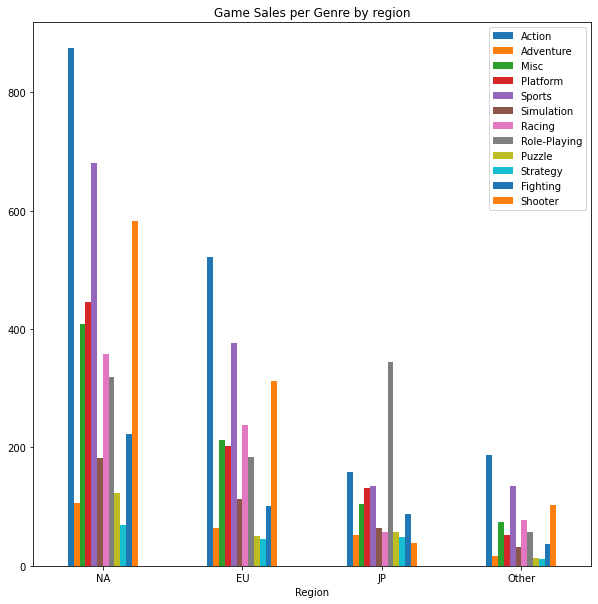

In [18]:
# 위 데이터는 막대그래프로 보는게 제일 보기 쉬울것으로 보이므로, 막대그래프로 시각화 해 보겠습니다.
import matplotlib.pyplot as plt
genre_barplot = genre_sales.plot.bar(title="Game Sales per Genre by region", rot=0, figsize=(10,10))
print(genre_barplot)
plt.show()

그래프에서 볼 수 있듯, 일본(JP)을 제외하고 모든 지역에서는 액션 게임이 제일 출고량이 많으며, 그 뒤로는 스포츠 게임, 슈팅 게임의 출고량이 많습니다.

일본의 경우, 롤플레잉 게임의 출고량이 1위이며, 그 뒤로 액션, 스포츠 게임의 출고량이 많습니다.

이 결과를 보면, 다음 분기 출시해야 할 게임 장르의 순위는
1. 액션
2. 스포츠
3. 슈팅

으로 생각할 수 있습니다.

(2) 연도별 게임 트렌드

In [19]:
# 우선 표 안에서 게임이 출시된 고유 연도를 찾습니다.
Year_list = game_data['Year'].unique()
Year_list = Year_list.tolist()
Year_list = sorted(Year_list)
Year_list.pop(36)
Year_list

[1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2020.0]

In [20]:
# (1)에서 사용한 코드를 수정해, 연도별로 우선 분류한 후 지역별로 출고량을 합치도록 만듭니다.
Genre_1980 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1980)].count()
    Genre_1980.append(j)

Genre_1981 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1981)].count()
    Genre_1981.append(j)
    
Genre_1982 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1982)].count()
    Genre_1982.append(j)

Genre_1983 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1983)].count()
    Genre_1983.append(j)

Genre_1984 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1984)].count()
    Genre_1984.append(j)

Genre_1985 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1985)].count()
    Genre_1985.append(j)
    
Genre_1986 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1986)].count()
    Genre_1986.append(j)

Genre_1987 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1987)].count()
    Genre_1987.append(j)

Genre_1988 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1988)].count()
    Genre_1988.append(j)

Genre_1989 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1989)].count()
    Genre_1989.append(j)

Genre_1990 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1990)].count()
    Genre_1990.append(j)

Genre_1991 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1991)].count()
    Genre_1991.append(j)

Genre_1992 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1992)].count()
    Genre_1992.append(j)

Genre_1993 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1993)].count()
    Genre_1993.append(j)

Genre_1994 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1994)].count()
    Genre_1994.append(j)

Genre_1995 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1995)].count()
    Genre_1995.append(j)

Genre_1996 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1996)].count()
    Genre_1996.append(j)

Genre_1997 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1997)].count()
    Genre_1997.append(j)

Genre_1998 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1998)].count()
    Genre_1998.append(j)

Genre_1999 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==1999)].count()
    Genre_1999.append(j)

Genre_2000 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2000)].count()
    Genre_2000.append(j)

Genre_2001 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2001)].count()
    Genre_2001.append(j)

Genre_2002 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2002)].count()
    Genre_2002.append(j)

Genre_2003 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2003)].count()
    Genre_2003.append(j)

Genre_2004 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2004)].count()
    Genre_2004.append(j)

Genre_2005 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2005)].count()
    Genre_2005.append(j)

Genre_2006 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2006)].count()
    Genre_2006.append(j)

Genre_2007 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2007)].count()
    Genre_2007.append(j)

Genre_2008 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2008)].count()
    Genre_2008.append(j)

Genre_2009 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2009)].count()
    Genre_2009.append(j)

Genre_2010 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2010)].count()
    Genre_2010.append(j)

Genre_2011 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2011)].count()
    Genre_2011.append(j)

Genre_2012 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2012)].count()
    Genre_2012.append(j)

Genre_2013 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2013)].count()
    Genre_2013.append(j)

Genre_2014 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2014)].count()
    Genre_2014.append(j)

Genre_2015 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2015)].count()
    Genre_2015.append(j)

Genre_2016 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2016)].count()
    Genre_2016.append(j)

Genre_2017 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2017)].count()
    Genre_2017.append(j)

Genre_2020 = []
for i in Genre_list:
    j = game_data['Year'][(game_data['Genre']==i) & (game_data['Year']==2020)].count()
    Genre_2020.append(j)

In [21]:
# (1)에서 했던 것처럼, 바로 위에서 계산된 list들을 dataframe으로 만들어, 연도별 각 장르의 출고 수를 표로 보여줍니다.

Year_genre = pd.DataFrame([Genre_1980])
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1981
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1982
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1983
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1984
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1985
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1986
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1987
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1988
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1989
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1990
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1991
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1992
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1993
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1994
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1995
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1996
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1997
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1998
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_1999
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2000
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2001
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2002
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2003
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2004
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2005
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2006
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2007
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2008
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2009
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2010
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2011
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2012
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2013
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2014
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2015
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2016
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2017
Year_genre = Year_genre.append(Year_genre.iloc[-1], ignore_index=True)
Year_genre.iloc[-1] = Genre_2020

In [22]:
Year_genre.columns = Genre_list
Year_genre['Year'] = Year_list
Year_genre = Year_genre.set_index(['Year'])

In [23]:
Year_genre

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Year,,,,,,,,,,,,
1980.0,1,0,4,0,0,0,0,0,0,0,1,2
1981.0,25,0,0,3,4,1,1,0,2,0,0,10
1982.0,18,0,1,5,2,0,2,0,3,0,0,5
1983.0,7,1,1,5,1,0,0,0,1,0,0,1
1984.0,1,0,1,1,2,0,3,0,3,0,0,3
1985.0,2,0,0,4,1,1,0,0,4,0,1,1
1986.0,6,0,0,6,3,0,1,1,0,0,0,4
1987.0,2,1,0,2,4,0,0,3,0,0,2,2
1988.0,2,0,0,4,2,1,1,3,1,0,0,1


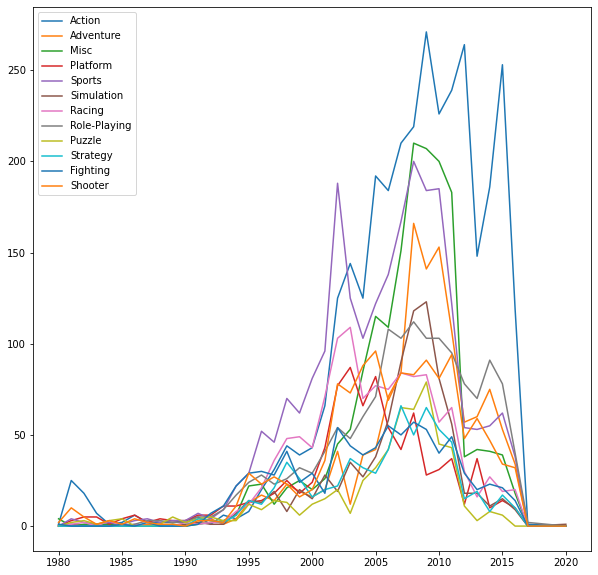

In [24]:
# 위 결과를 꺽은선 그래프로 이를 표현해 보겠습니다.
plt.figure(figsize=(10,10))
plt.plot(Year_list,Year_genre['Action'], label = 'Action')
plt.plot(Year_list,Year_genre['Adventure'], label = 'Adventure')
plt.plot(Year_list,Year_genre['Misc'], label = 'Misc')
plt.plot(Year_list,Year_genre['Platform'], label = 'Platform')
plt.plot(Year_list,Year_genre['Sports'], label = 'Sports')
plt.plot(Year_list,Year_genre['Simulation'], label = 'Simulation')
plt.plot(Year_list,Year_genre['Racing'], label = 'Racing')
plt.plot(Year_list,Year_genre['Role-Playing'], label = 'Role-Playing')
plt.plot(Year_list,Year_genre['Puzzle'], label = 'Puzzle')
plt.plot(Year_list,Year_genre['Strategy'], label = 'Strategy')
plt.plot(Year_list,Year_genre['Fighting'], label = 'Fighting')
plt.plot(Year_list,Year_genre['Shooter'], label = 'Shooter')
plt.legend()
plt.show()

그래프를 보면, 2020년은 데이터가 부족한 것으로 판단되고, 장르는 1980년~85년 사이 액션게임의 인기가 반짝 상승했다가 전체적으로 출시 수가 감소함을 볼 수 있습니다.

그 후, 모든 게임의 출시 수가 늘어나지만 1995~2000년에는 스포츠 게임이 가장 많이, 그 후로는 액션 게임의 수가 가장 많이 증가함을 알 수 있습니다.

이를 볼 때, 2020년 이후로도 액션 게임이 가장 많이 출고될 거라고 생각할 수 있습니다.



(3) 출고량이 높은 게임에 대한 확인

In [25]:
# 우선, 4개 지역 판매량을 합친 전체 판매량 1~10위 게임을 확인합니다.
game_data['Total_Sales'] = game_data['NA_Sales'] + game_data['EU_Sales'] + game_data['JP_Sales'] + game_data['Other_Sales']

In [26]:
game_data

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [27]:
game_data_sort_total = game_data.sort_values('Total_Sales', ascending=[False])

In [28]:
game_data_sort_total.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16531,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10488,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


In [29]:
# 이제 4개 지역에서 게임 출고량 순위가 어떤지 확인하겠습니다.
game_data_sort_NA = game_data.sort_values('NA_Sales', ascending=[False])
game_data_sort_EU = game_data.sort_values('EU_Sales', ascending=[False])
game_data_sort_JP = game_data.sort_values('JP_Sales', ascending=[False])
game_data_sort_Other = game_data.sort_values('Other_Sales', ascending=[False])

In [30]:
game_data_sort_NA.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
10488,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31
1203,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4343,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
16531,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
13111,Super Mario World,SNES,1990.0,Platform,Nintendo,12.78,3.75,3.54,0.55,20.62


In [31]:
game_data_sort_EU.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
11137,Nintendogs,DS,2005.0,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.75
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
13229,Brain Age: Train Your Brain in Minutes a Day,DS,2005.0,Misc,Nintendo,4.75,9.26,4.16,2.05,20.22
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
10899,Wii Fit Plus,Wii,2009.0,Sports,Nintendo,9.09,8.59,2.53,1.79,22.00


In [32]:
game_data_sort_JP.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
7829,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
9416,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,Nintendo,9.00,6.18,7.20,0.71,23.09
4199,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
10555,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,Nintendo,6.42,4.52,6.04,1.37,18.35
10621,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
10917,Pokemon Ruby/Pokemon Sapphire,GBA,2002.0,Role-Playing,Nintendo,6.06,3.90,5.38,0.50,15.84
3273,Animal Crossing: Wild World,DS,2005.0,Simulation,Nintendo,2.55,3.52,5.33,0.88,12.28
511,Brain Age 2: More Training in Minutes a Day,DS,2005.0,Puzzle,Nintendo,3.44,5.36,5.32,1.18,15.30
1847,Monster Hunter Freedom 3,PSP,2010.0,Role-Playing,Capcom,0.00,0.00,4.87,0.00,4.87


In [33]:
game_data_sort_Other.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
14669,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
14665,Gran Turismo 4,PS2,2004.0,Racing,Sony Computer Entertainment,3.01,0.01,1.10,7.53,11.65
3483,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
12579,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
8213,Pro Evolution Soccer 2008,PS2,2007.0,Sports,Konami Digital Entertainment,0.05,0.00,0.64,2.93,3.62
6937,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,Wii Play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
11137,Nintendogs,DS,2005.0,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.75


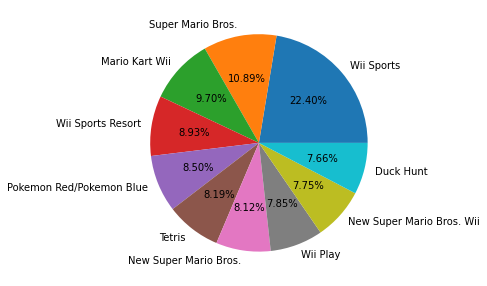

In [34]:
# 이제 위 5개에 대한 그래프를, 10위까지만 잘라서 그려 보겠습니다

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.pie(x=game_data_sort_total['Total_Sales'].head(10), labels = game_data_sort_total['Name'].head(10), autopct=lambda p : '{:.2f}%'.format(p))
plt.show()

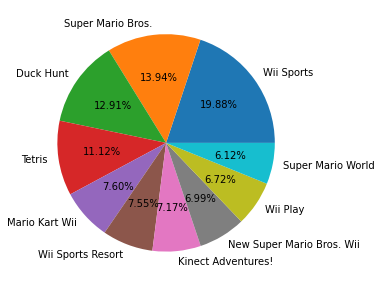

In [35]:
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax_2 = fig.add_subplot()
ax_2.pie(x=game_data_sort_NA['NA_Sales'].head(10), labels = game_data_sort_NA['Name'].head(10), autopct=lambda p : '{:.2f}%'.format(p))
plt.show()

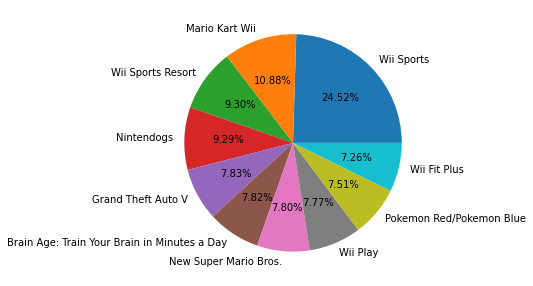

In [36]:
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax_3 = fig.add_subplot()
ax_3.pie(x=game_data_sort_EU['EU_Sales'].head(10), labels = game_data_sort_EU['Name'].head(10), autopct=lambda p : '{:.2f}%'.format(p))
plt.show()

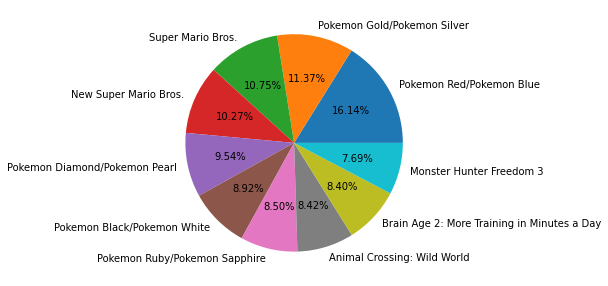

In [37]:
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax_4 = fig.add_subplot()
ax_4.pie(x=game_data_sort_JP['JP_Sales'].head(10), labels = game_data_sort_JP['Name'].head(10), autopct=lambda p : '{:.2f}%'.format(p))
plt.show()

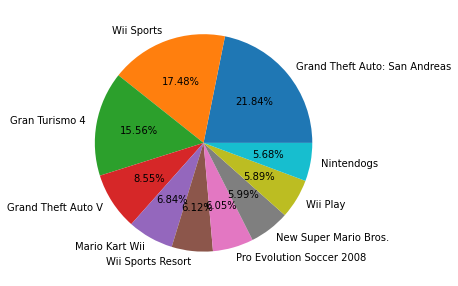

In [38]:
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
ax_5 = fig.add_subplot()
ax_5.pie(x=game_data_sort_Other['Other_Sales'].head(10), labels = game_data_sort_Other['Name'].head(10), autopct=lambda p : '{:.2f}%'.format(p))
plt.show()

In [39]:
# 상위권 게임들의 판매량이 대체로 백만장(1M)을 넘는다는것을 알았으니, 이 기준으로 그래프를 다시 확인합니다.

In [40]:
# 4개 지역에서, 1M(백만장) 넘게 출고된 게임들의 장르를 분석하면 다음과 같습니다.

In [41]:
game_data_NA_1m = game_data.copy()
delete_row_NA = game_data_NA_1m[game_data_NA_1m['NA_Sales'] < 1].index
game_data_NA_1m = game_data_NA_1m.drop(delete_row_NA)

NA_Genre_Sales_M = []
for i in Genre_list:
  i = game_data_NA_1m.loc[game_data_NA_1m['Genre'] == i, 'NA_Sales'].sum()
  NA_Genre_Sales_M.append(i)

In [42]:
game_data_EU_1m = game_data.copy()
delete_row_EU = game_data_EU_1m[game_data_EU_1m['EU_Sales'] < 1].index
game_data_EU_1m = game_data_EU_1m.drop(delete_row_EU)

EU_Genre_Sales_M = []
for i in Genre_list:
  i = game_data_EU_1m.loc[game_data_EU_1m['Genre'] == i, 'EU_Sales'].sum()
  EU_Genre_Sales_M.append(i)

In [43]:
game_data_JP_1m = game_data.copy()
delete_row_JP = game_data_JP_1m[game_data_JP_1m['JP_Sales'] < 1].index
game_data_JP_1m = game_data_JP_1m.drop(delete_row_JP)

JP_Genre_Sales_M = []
for i in Genre_list:
  i = game_data_JP_1m.loc[game_data_JP_1m['Genre'] == i, 'JP_Sales'].sum()
  JP_Genre_Sales_M.append(i)

In [44]:
game_data_Other_1m = game_data.copy()
delete_row_Other = game_data_Other_1m[game_data_Other_1m['Other_Sales'] < 1].index
game_data_Other_1m = game_data_Other_1m.drop(delete_row_Other)

Other_Genre_Sales_M = []
for i in Genre_list:
  i = game_data_Other_1m.loc[game_data_Other_1m['Genre'] == i, 'Other_Sales'].sum()
  Other_Genre_Sales_M.append(i)

In [45]:
genre_sales_M = pd.DataFrame([NA_Genre_Sales_M])
genre_sales_M = genre_sales_M.append(genre_sales_M.iloc[-1], ignore_index=True)
genre_sales_M.iloc[-1] = EU_Genre_Sales_M
genre_sales_M = genre_sales_M.append(genre_sales_M.iloc[-1], ignore_index=True)
genre_sales_M.iloc[-1] = JP_Genre_Sales_M
genre_sales_M = genre_sales_M.append(genre_sales_M.iloc[-1], ignore_index=True)
genre_sales_M.iloc[-1] = Other_Genre_Sales_M

In [46]:
genre_sales_M.columns = Genre_list
genre_sales_M['Region'] = Region
genre_sales_M = genre_sales_M.set_index(['Region'])

In [47]:
genre_sales_M

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
Region,,,,,,,,,,,,
NA,374.30,30.40,186.70,287.69,291.04,61.61,165.09,162.60,61.58,26.75,104.10,358.06
EU,192.53,13.84,86.24,95.36,176.48,48.06,97.48,89.93,18.41,11.69,27.49,144.69
JP,28.30,5.36,37.49,77.27,43.21,23.57,28.19,177.83,24.42,6.59,23.88,4.91
Other,38.78,0.00,12.56,5.16,35.09,2.75,19.83,7.21,1.18,0.00,3.52,22.10


AxesSubplot(0.125,0.125;0.775x0.755)


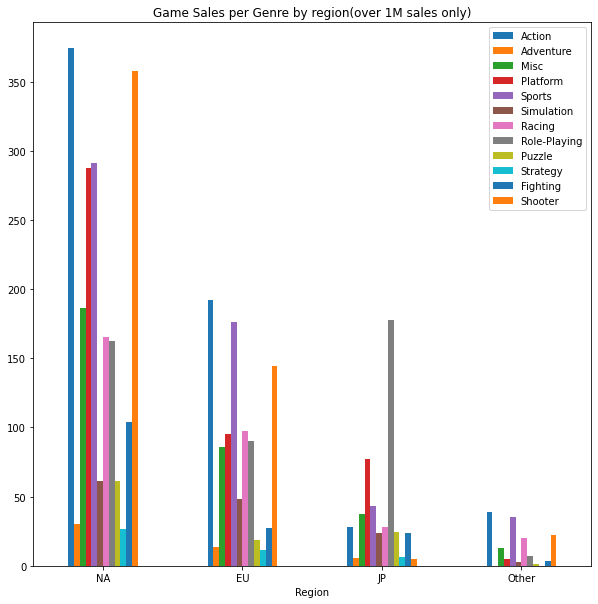

In [48]:
genre_M_barplot = genre_sales_M.plot.bar(title="Game Sales per Genre by region(over 1M sales only)", rot=0, figsize=(10,10))
print(genre_M_barplot)
plt.show()

(4) 판매 플랫폼과 게임 출고량



In [49]:
# 게임이 판매되는 플랫폼 또한 중요하게 생각할 수 있으며, 이를 위해 우선 서로 다른 플랫폼 이름을 확인합니다.
print(game_data['Platform'].unique())

['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' nan '3DO' 'GG' 'PCFX']


In [50]:
# 확인해 본 결과, 위의 플랫폼들 중 일부는 제조 회사에서 이름을 바꾸어 출시하는 기종들이므로, 회사별로 분류해 보면 다음과 같습니다.
# Nintendo : DS, Wii, GBA, GC, 3DS, GB, NES, N64, SNES, WiiU
# Sony : PSP, PS3, PS, PS4, PS2, PSV, GEN
# Microsoft : XB, X360, XOne
# Atari : 2600
# Sega : SAT, GEN, SCD(sega CD), GG(game gear)
# EA : 3DO
# BANDAI : WS(wonderswan)
# SNK : NG(neo-geo)
# NEC Corporation : TG16(turbografix 16), PCFX(PC-FX, 허드슨소프트와 공동개발)
# PC는 일반 개인용 컴퓨터입니다.

In [51]:
# 우선, 각 플랫폼다의 출고량을 확인하겠습니다.
Platform_list = game_data['Platform'].unique()
Platform_list = Platform_list.tolist()
Platform_list.pop(28)
Platform_list

['DS',
 'Wii',
 'PSP',
 'PS3',
 'PC',
 'PS',
 'GBA',
 'PS4',
 'PS2',
 'XB',
 'X360',
 'GC',
 '3DS',
 '2600',
 'SAT',
 'GB',
 'NES',
 'DC',
 'N64',
 'XOne',
 'SNES',
 'WiiU',
 'PSV',
 'GEN',
 'SCD',
 'WS',
 'NG',
 'TG16',
 '3DO',
 'GG',
 'PCFX']

In [52]:
# 먼저 플랫폼별 지역에서의 출고량을 확인합니다.
NA_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'NA_Sales'].sum()
  NA_Platform_Sales.append(i)

EU_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'EU_Sales'].sum()
  EU_Platform_Sales.append(i)

JP_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'JP_Sales'].sum()
  JP_Platform_Sales.append(i)

Other_Platform_Sales = []
for i in Platform_list:
  i = game_data.loc[game_data['Platform'] == i, 'Other_Sales'].sum()
  Other_Platform_Sales.append(i)

In [53]:
platform_sales = pd.DataFrame([NA_Platform_Sales])
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = EU_Platform_Sales
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = JP_Platform_Sales
platform_sales = platform_sales.append(platform_sales.iloc[-1], ignore_index=True)
platform_sales.iloc[-1] = Other_Platform_Sales

In [54]:
platform_sales.columns = Platform_list
platform_sales['Region'] = Region
platform_sales = platform_sales.set_index(['Region'])

In [55]:
platform_sales

,DS,Wii,PSP,PS3,PC,PS,GBA,PS4,PS2,XB,X360,GC,3DS,2600,SAT,GB,NES,DC,N64,XOne,SNES,WiiU,PSV,GEN,SCD,WS,NG,TG16,3DO,GG,PCFX
Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NA,390.71,507.71,108.99,392.26,93.28,336.51,187.54,96.80,583.84,186.69,601.05,133.46,78.87,90.60,0.72,114.32,125.94,5.43,139.02,83.19,61.23,38.32,16.20,19.27,1.00,0.00,0.00,0.00,0.0,0.00,0.00
EU,194.65,268.38,68.25,343.71,139.68,213.60,75.25,123.70,339.29,60.95,280.58,38.71,58.52,5.47,0.54,47.82,21.15,1.69,41.06,45.65,19.04,24.23,16.33,5.52,0.36,0.00,0.00,0.00,0.0,0.00,0.00
JP,175.57,69.35,76.75,79.91,0.17,139.82,47.33,14.30,139.20,1.38,12.43,21.58,97.35,0.00,32.26,85.12,98.65,8.56,34.22,0.34,116.55,12.79,20.96,2.67,0.45,1.42,1.44,0.16,0.1,0.04,0.03
Other,60.53,80.61,42.19,141.93,24.86,40.91,7.73,43.36,193.44,8.72,85.54,5.18,12.63,0.91,0.07,8.20,5.31,0.27,4.38,11.92,3.22,6.45,8.45,0.89,0.05,0.00,0.00,0.00,0.0,0.00,0.00


AxesSubplot(0.125,0.125;0.775x0.755)


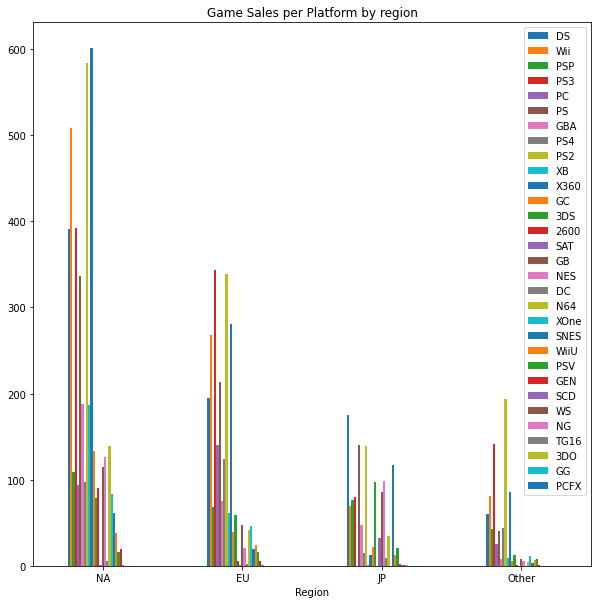

In [56]:
platform_barplot = platform_sales.plot.bar(title="Game Sales per Platform by region", rot=0, figsize=(10,10))
print(platform_barplot)
plt.show()

In [57]:
# 그래프를 보면, 플랫폼이 너무 많아서 구분이 힘들 뿐더러, 이 구분으로는 단종된 게임 플랫폼까지 같이 보게 되므로 게임을 출시할 플랫폼을 결정하기가 힘듭니다.
# (예 : 기타 지역은 PS2로 제일 많은 게임이 출시되었는데, 2012년 단종된 게임기입니다.)
# 그래서, 회사별로 분류한 항목을 참조해 다시 분류해 보겠습니다.

In [58]:
game_data_platform_sorted = game_data.copy()

In [59]:
game_data_platform_sorted['Platform'].replace({'DS': 'Nintendo', 'Wii': 'Nintendo', 'GBA': 'Nintendo', 'GC': 'Nintendo', '3DS': 'Nintendo',
                                               'GB': 'Nintendo', 'NES': 'Nintendo', 'N64': 'Nintendo', 'SNES': 'Nintendo', 'WiiU': 'Nintendo'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'PSP': 'Sony', 'PS3': 'Sony', 'PS': 'Sony', 'PS4': 'Sony', 'PS2': 'Sony',
                                               'PSV': 'Sony'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'XB': 'Microsoft', 'X360': 'Microsoft', 'XOne': 'Microsoft'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'2600': 'Atari'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'SAT': 'Sega', 'GEN': 'Sega', 'SCD': 'Sega', 'GG': 'Sega', 'DC': 'Sega'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'WS': 'Bandai'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'NG': 'SNK'}, inplace=True)
game_data_platform_sorted['Platform'].replace({'TG16': 'NEC', 'PCFX': 'NEC'}, inplace=True)

In [60]:
game_data_platform_sorted

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,Nintendo,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Nintendo,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,Sony,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,Nintendo,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,Sony,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,Nintendo,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,Sony,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,Sony,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,Sony,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [61]:
Platform_list_2 = game_data_platform_sorted['Platform'].unique()
Platform_list_2 = Platform_list_2.tolist()
Platform_list_2.pop(9)
Platform_list_2

['Nintendo',
 'Sony',
 'PC',
 'Microsoft',
 'Atari',
 'Sega',
 'Bandai',
 'SNK',
 'NEC',
 '3DO']

In [62]:
NA_Platform_Sales_2 = []
for i in Platform_list_2:
  i = game_data_platform_sorted.loc[game_data_platform_sorted['Platform'] == i, 'NA_Sales'].sum()
  NA_Platform_Sales_2.append(i)

EU_Platform_Sales_2 = []
for i in Platform_list_2:
  i = game_data_platform_sorted.loc[game_data_platform_sorted['Platform'] == i, 'EU_Sales'].sum()
  EU_Platform_Sales_2.append(i)

JP_Platform_Sales_2 = []
for i in Platform_list_2:
  i = game_data_platform_sorted.loc[game_data_platform_sorted['Platform'] == i, 'JP_Sales'].sum()
  JP_Platform_Sales_2.append(i)

Other_Platform_Sales_2 = []
for i in Platform_list_2:
  i = game_data_platform_sorted.loc[game_data_platform_sorted['Platform'] == i, 'Other_Sales'].sum()
  Other_Platform_Sales_2.append(i)

In [63]:
platform_sales_2 = pd.DataFrame([NA_Platform_Sales_2])
platform_sales_2 = platform_sales_2.append(platform_sales_2.iloc[-1], ignore_index=True)
platform_sales_2.iloc[-1] = EU_Platform_Sales_2
platform_sales_2 = platform_sales_2.append(platform_sales_2.iloc[-1], ignore_index=True)
platform_sales_2.iloc[-1] = JP_Platform_Sales_2
platform_sales_2 = platform_sales_2.append(platform_sales_2.iloc[-1], ignore_index=True)
platform_sales_2.iloc[-1] = Other_Platform_Sales_2

In [64]:
platform_sales_2.columns = Platform_list_2
platform_sales_2['Region'] = Region
platform_sales_2 = platform_sales_2.set_index(['Region'])

In [65]:
platform_sales_2

,Nintendo,Sony,PC,Microsoft,Atari,Sega,Bandai,SNK,NEC,3DO
Region,,,,,,,,,,
NA,1777.12,1534.60,93.28,870.93,90.60,26.42,0.00,0.00,0.00,0.0
EU,788.81,1104.88,139.68,387.18,5.47,8.11,0.00,0.00,0.00,0.0
JP,758.51,470.94,0.17,14.15,0.00,43.98,1.42,1.44,0.19,0.1
Other,194.24,470.28,24.86,106.18,0.91,1.28,0.00,0.00,0.00,0.0


AxesSubplot(0.125,0.125;0.775x0.755)


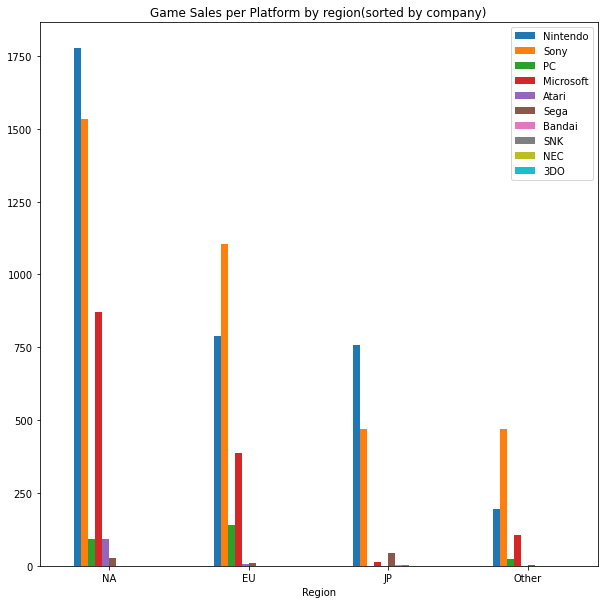

In [66]:
platform_barplot_2 = platform_sales_2.plot.bar(title="Game Sales per Platform by region(sorted by company)", rot=0, figsize=(10,10))
print(platform_barplot_2)
plt.show()

위 그래프를 볼 때, 전체적으로는 닌텐도의 게임 플랫폼에서 판매율이 제일 높고, 그 다음이 소니, 그 다음이 마이크로소프트인것으로 볼 수 있습니다.

다만 유럽과 그 외 지역은 닌텐도보다 소니 게임 플랫폼의 판매율이 높으며, 일본에선 마이크로소프트의 게임기가 거의 팔리지 않았습니다.

그래프를 볼 때, 사실상 닌텐도, 소니, 마이크르소프트 게임 플랫폼에서의 출고량이 대부분이고 그 다음 PC가 약간의 지분을 차지하고 있으며, 그 외 회사 플랫폼은 매우 작은 양만을 차지합니다.

하지만, 위 그래프는 시간에 따른 플랫폼의 게임 출고량을 보여주는 그래프는 아닙니다. 따라서 극단적인 예로, 닌텐도 게임기로 1980, 90년대에 천만장의 게임이 나오고 그 후로 전혀 안나왔다고 하더라도 2000~2020년 사이 다른 게임기의 출고량이 적다면 닌텐도 게임기로 게임을 출시해야 한다는 결론이 날 수 있습니다.

따라서, 시간에 따른 플랫폼별 게임 출고량 또한 확인해 보겠습니다.

In [67]:
Platform_1980 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1980)].count()
    Platform_1980.append(j)

Platform_1981 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1981)].count()
    Platform_1981.append(j)
    
Platform_1982 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1982)].count()
    Platform_1982.append(j)

Platform_1983 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1983)].count()
    Platform_1983.append(j)

Platform_1984 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1984)].count()
    Platform_1984.append(j)

Platform_1985 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1985)].count()
    Platform_1985.append(j)
    
Platform_1986 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1986)].count()
    Platform_1986.append(j)

Platform_1987 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1987)].count()
    Platform_1987.append(j)

Platform_1988 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1988)].count()
    Platform_1988.append(j)

Platform_1989 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1989)].count()
    Platform_1989.append(j)

Platform_1990 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1990)].count()
    Platform_1990.append(j)

Platform_1991 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1991)].count()
    Platform_1991.append(j)

Platform_1992 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1992)].count()
    Platform_1992.append(j)

Platform_1993 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1993)].count()
    Platform_1993.append(j)

Platform_1994 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1994)].count()
    Platform_1994.append(j)

Platform_1995 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1995)].count()
    Platform_1995.append(j)

Platform_1996 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1996)].count()
    Platform_1996.append(j)

Platform_1997 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1997)].count()
    Platform_1997.append(j)

Platform_1998 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1998)].count()
    Platform_1998.append(j)

Platform_1999 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==1999)].count()
    Platform_1999.append(j)

Platform_2000 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2000)].count()
    Platform_2000.append(j)

Platform_2001 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2001)].count()
    Platform_2001.append(j)

Platform_2002 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2002)].count()
    Platform_2002.append(j)

Platform_2003 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2003)].count()
    Platform_2003.append(j)

Platform_2004 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2004)].count()
    Platform_2004.append(j)

Platform_2005 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2005)].count()
    Platform_2005.append(j)

Platform_2006 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2006)].count()
    Platform_2006.append(j)

Platform_2007 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2007)].count()
    Platform_2007.append(j)

Platform_2008 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2008)].count()
    Platform_2008.append(j)

Platform_2009 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2009)].count()
    Platform_2009.append(j)

Platform_2010 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2010)].count()
    Platform_2010.append(j)

Platform_2011 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2011)].count()
    Platform_2011.append(j)

Platform_2012 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2012)].count()
    Platform_2012.append(j)

Platform_2013 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2013)].count()
    Platform_2013.append(j)

Platform_2014 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2014)].count()
    Platform_2014.append(j)

Platform_2015 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2015)].count()
    Platform_2015.append(j)

Platform_2016 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2016)].count()
    Platform_2016.append(j)

Platform_2017 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2017)].count()
    Platform_2017.append(j)

Platform_2020 = []
for i in Platform_list_2:
    j = game_data_platform_sorted['Year'][(game_data_platform_sorted['Platform']==i) & (game_data_platform_sorted['Year']==2020)].count()
    Platform_2020.append(j)

In [68]:
Year_platform = pd.DataFrame([Platform_1980])
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1981
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1982
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1983
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1984
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1985
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1986
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1987
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1988
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1989
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1990
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1991
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1992
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1993
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1994
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1995
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1996
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1997
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1998
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_1999
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2000
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2001
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2002
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2003
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2004
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2005
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2006
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2007
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2008
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2009
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2010
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2011
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2012
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2013
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2014
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2015
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2016
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2017
Year_platform = Year_platform.append(Year_platform.iloc[-1], ignore_index=True)
Year_platform.iloc[-1] = Platform_2020

In [69]:
Year_platform.columns = Platform_list_2
Year_platform['Year'] = Year_list
Year_platform = Year_platform.set_index(['Year'])

In [70]:
Year_platform

,Nintendo,Sony,PC,Microsoft,Atari,Sega,Bandai,SNK,NEC,3DO
Year,,,,,,,,,,
1980.0,0,0,0,0,9,0,0,0,0,0
1981.0,0,0,0,0,46,0,0,0,0,0
1982.0,0,0,0,0,36,0,0,0,0,0
1983.0,6,0,0,0,11,0,0,0,0,0
1984.0,13,0,0,0,1,0,0,0,0,0
1985.0,12,0,1,0,1,0,0,0,0,0
1986.0,19,0,0,0,2,0,0,0,0,0
1987.0,10,0,0,0,6,0,0,0,0,0
1988.0,12,0,1,0,2,0,0,0,0,0


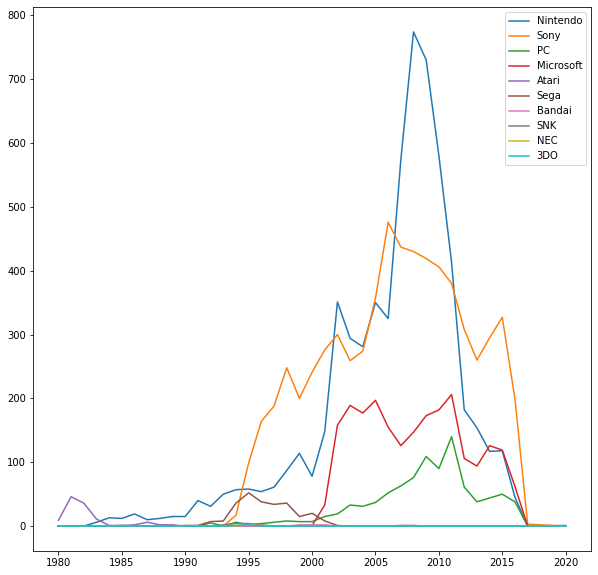

In [71]:
plt.figure(figsize=(10,10))
plt.plot(Year_list,Year_platform['Nintendo'], label = 'Nintendo')
plt.plot(Year_list,Year_platform['Sony'], label = 'Sony')
plt.plot(Year_list,Year_platform['PC'], label = 'PC')
plt.plot(Year_list,Year_platform['Microsoft'], label = 'Microsoft')
plt.plot(Year_list,Year_platform['Atari'], label = 'Atari')
plt.plot(Year_list,Year_platform['Sega'], label = 'Sega')
plt.plot(Year_list,Year_platform['Bandai'], label = 'Bandai')
plt.plot(Year_list,Year_platform['SNK'], label = 'SNK')
plt.plot(Year_list,Year_platform['NEC'], label = 'NEC')
plt.plot(Year_list,Year_platform['3DO'], label = '3DO')
plt.legend()
plt.show()

그래프를 보면, 닌텐도가 1995년도까지 1위를 달리다가 소니가 2000년도까지 1위를 하였으며, 2010년도에 다시 닌텐도가 앞서나가고 2010~2015년 사이로 소니가 1위를 재탈환한 것을 볼 수 있습니다.

따라서, 위 결과들을 보면 게임 플랫폼을 결정 할 때의 순위는

1. 소니 2. 닌텐도 3.마이크로소프트

로 생각할 수 있을 것으로 보입니다.

이제, 상위권 게임들만 추려서 백만장 이상 출고된 게임들은 어떤 플랫폼으로 나왔는지 보겠습니다.

In [72]:
# 4개 지역에서, 1M(백만장) 넘게 출고된 게임들의 판매 플랫폼을 분석하면 다음과 같습니다.

In [73]:
NA_Platform_Sales_M = []
for i in Platform_list:
  i = game_data_NA_1m.loc[game_data_NA_1m['Platform'] == i, 'NA_Sales'].sum()
  NA_Platform_Sales_M.append(i)

EU_Platform_Sales_M = []
for i in Platform_list:
  i = game_data_EU_1m.loc[game_data_EU_1m['Platform'] == i, 'EU_Sales'].sum()
  EU_Platform_Sales_M.append(i)

JP_Platform_Sales_M = []
for i in Platform_list:
  i = game_data_JP_1m.loc[game_data_JP_1m['Platform'] == i, 'JP_Sales'].sum()
  JP_Platform_Sales_M.append(i)

Other_Platform_Sales_M = []
for i in Platform_list:
  i = game_data_Other_1m.loc[game_data_Other_1m['Platform'] == i, 'Other_Sales'].sum()
  Other_Platform_Sales_M.append(i)

In [74]:
platform_sales_M = pd.DataFrame([NA_Platform_Sales_M])
platform_sales_M = platform_sales_M.append(platform_sales_M.iloc[-1], ignore_index=True)
platform_sales_M.iloc[-1] = EU_Platform_Sales_M
platform_sales_M = platform_sales_M.append(platform_sales_M.iloc[-1], ignore_index=True)
platform_sales_M.iloc[-1] = JP_Platform_Sales_M
platform_sales_M = platform_sales_M.append(platform_sales_M.iloc[-1], ignore_index=True)
platform_sales_M.iloc[-1] = Other_Platform_Sales_M

In [75]:
platform_sales_M.columns = Platform_list
platform_sales_M['Region'] = Region
platform_sales_M = platform_sales_M.set_index(['Region'])

In [76]:
platform_sales_M

,DS,Wii,PSP,PS3,PC,PS,GBA,PS4,PS2,XB,X360,GC,3DS,2600,SAT,GB,NES,DC,N64,XOne,SNES,WiiU,PSV,GEN,SCD,WS,NG,TG16,3DO,GG,PCFX
Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NA,135.02,268.19,16.78,171.57,55.76,166.03,58.65,52.08,280.19,41.77,346.10,35.92,36.85,46.02,0.0,97.27,102.68,4.5,75.99,45.07,50.75,16.70,0.0,17.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0
EU,104.64,151.75,15.57,153.29,52.55,85.07,15.53,75.49,128.16,3.87,109.38,4.07,28.11,0.00,0.0,31.10,8.20,0.0,11.06,14.09,8.85,7.80,0.0,1.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JP,89.30,35.93,11.78,2.95,0.00,50.69,11.98,0.00,30.52,0.00,0.00,1.39,50.20,0.00,1.3,58.27,72.23,0.0,15.33,0.00,55.42,3.98,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Other,12.17,25.87,2.96,32.65,1.18,0.00,0.00,10.76,51.67,0.00,10.15,0.00,0.00,0.00,0.0,1.00,1.51,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.775x0.755)


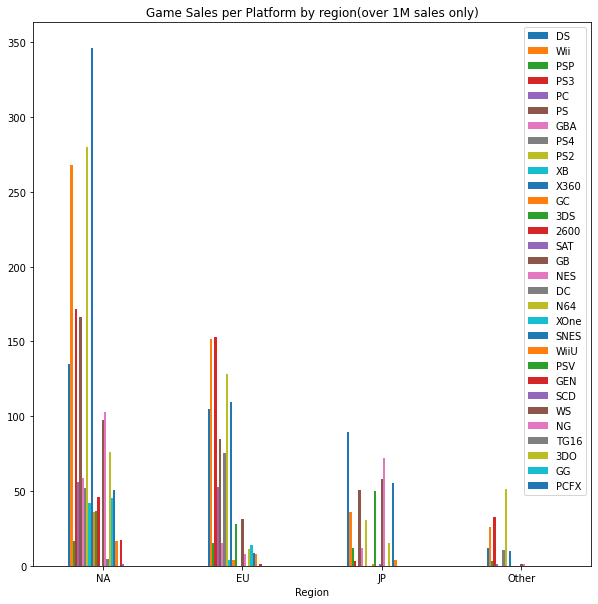

In [77]:
platform_M_barplot = platform_sales_M.plot.bar(title="Game Sales per Platform by region(over 1M sales only)", rot=0, figsize=(10,10))
print(platform_M_barplot)
plt.show()

In [78]:
# 데이터를 볼 때, NA는 X360가 1위, EU는 PS3, JP는 DS, Other에서는 PS2 기종에서 제일 많은 제품이 팔렸습니다.
# 하지만 이렇게 봐서는 구분이 안되는건 마찬가지니, 회사별로 묶어서 확인해 보겠습니다.

In [79]:
game_data_NA_1m_2 = game_data_platform_sorted.copy()
delete_row_NA_2 = game_data_NA_1m_2[game_data_NA_1m_2['NA_Sales'] < 1].index
game_data_NA_1m_2 = game_data_NA_1m_2.drop(delete_row_NA)
game_data_EU_1m_2 = game_data_platform_sorted.copy()
delete_row_EU_2 = game_data_EU_1m_2[game_data_EU_1m_2['EU_Sales'] < 1].index
game_data_EU_1m_2 = game_data_EU_1m_2.drop(delete_row_EU)
game_data_JP_1m_2 = game_data_platform_sorted.copy()
delete_row_JP_2 = game_data_JP_1m_2[game_data_JP_1m_2['JP_Sales'] < 1].index
game_data_JP_1m_2 = game_data_JP_1m_2.drop(delete_row_JP)
game_data_Other_1m_2 = game_data_platform_sorted.copy()
delete_row_Other_2 = game_data_Other_1m_2[game_data_Other_1m_2['Other_Sales'] < 1].index
game_data_Other_1m_2 = game_data_Other_1m_2.drop(delete_row_Other)

In [80]:
NA_Platform_Sales_2_M = []
for i in Platform_list_2:
  i = game_data_NA_1m_2.loc[game_data_NA_1m_2['Platform'] == i, 'NA_Sales'].sum()
  NA_Platform_Sales_2_M.append(i)

EU_Platform_Sales_2_M = []
for i in Platform_list_2:
  i = game_data_EU_1m_2.loc[game_data_EU_1m_2['Platform'] == i, 'EU_Sales'].sum()
  EU_Platform_Sales_2_M.append(i)

JP_Platform_Sales_2_M = []
for i in Platform_list_2:
  i = game_data_JP_1m_2.loc[game_data_JP_1m_2['Platform'] == i, 'JP_Sales'].sum()
  JP_Platform_Sales_2_M.append(i)

Other_Platform_Sales_2_M = []
for i in Platform_list_2:
  i = game_data_Other_1m_2.loc[game_data_Other_1m_2['Platform'] == i, 'Other_Sales'].sum()
  Other_Platform_Sales_2_M.append(i)

In [81]:
platform_sales_sorted_M = pd.DataFrame([NA_Platform_Sales_2_M])
platform_sales_sorted_M = platform_sales_sorted_M.append(platform_sales_sorted_M.iloc[-1], ignore_index=True)
platform_sales_sorted_M.iloc[-1] = EU_Platform_Sales_2_M
platform_sales_sorted_M = platform_sales_sorted_M.append(platform_sales_sorted_M.iloc[-1], ignore_index=True)
platform_sales_sorted_M.iloc[-1] = JP_Platform_Sales_2_M
platform_sales_sorted_M = platform_sales_sorted_M.append(platform_sales_sorted_M.iloc[-1], ignore_index=True)
platform_sales_sorted_M.iloc[-1] = Other_Platform_Sales_2_M

In [82]:
platform_sales_sorted_M.columns = Platform_list_2
platform_sales_sorted_M['Region'] = Region
platform_sales_sorted_M = platform_sales_sorted_M.set_index(['Region'])

In [83]:
platform_sales_sorted_M

,Nintendo,Sony,PC,Microsoft,Atari,Sega,Bandai,SNK,NEC,3DO
Region,,,,,,,,,,
NA,878.02,686.65,55.76,432.94,46.02,22.85,0.0,0.0,0.0,0.0
EU,371.11,457.58,52.55,127.34,0.00,1.20,0.0,0.0,0.0,0.0
JP,394.03,95.94,0.00,0.00,0.00,1.30,0.0,0.0,0.0,0.0
Other,40.55,98.04,1.18,10.15,0.00,0.00,0.0,0.0,0.0,0.0


AxesSubplot(0.125,0.125;0.775x0.755)


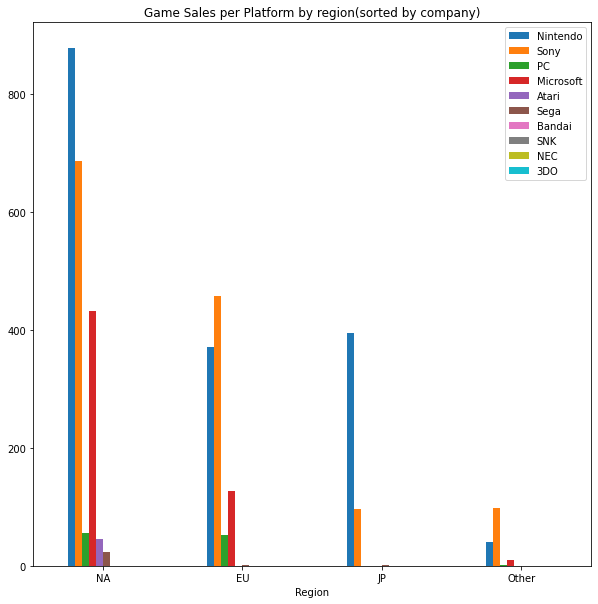

In [84]:
platform_barplot_sorted_2 = platform_sales_sorted_M.plot.bar(title="Game Sales per Platform by region(sorted by company)", rot=0, figsize=(10,10))
print(platform_barplot_sorted_2)
plt.show()

In [85]:
# 왼쪽부터, 각 지역마다 닌텐도, 소니, 닌텐도, 소니의 게임기로 제일 많은 게임이 출고되었음을 알 수 있습니다.
# 다만, 북미지역 출고량이 다른 지역들보다 훨씬 많아서 전체적으로는 닌텐도가 1위, 소니가 2위임을 알 수 있습니다.(3위는 마이크로소프트입니다.)
# 북미가 가장 특이한데, 전체 게임 출고량으로는 X360(마이크로소프트)가 1위이나 백만장 이상 팔린 게임이 출시된 게임기는 닌텐도가 1위, 소니가 2위이고 마이크로소프트는 3위로 내려옵니다.

(5) 결론

위 결과들을 볼 때, 만약 단 한 지역에서 한 장르로 한 기종만을 지원할 게임을 만든다면

지역 : 제일 많은 게임이 출시된 '북미'

장르 : 일본을 제외하고 전 지역에서 가장 많은 출고량을 보인 '액션' 장르

기종 : 2015년 이후 지금까지 게임 출고량이 제일 많은 '소니' 회사의 게임기

로 만드는것이 제일 많은 출고량을 보일 수 있을 것 같으며, 지역별로 장르를 다르게 판매한다면

(1) 북미 : 액션 게임

(2) 유럽 : 액션 게임

(3) 일본 : 롤플레잉 게임

(4) 기타 : 액션 게임

로 게임을 발매하는것이 가장 높은 출고율을 보일 것으로 생각됩니다.